# Protein Structure Geometry 

## Set-up

These functions are necessairy to calculate the volume and surface area of a protein structure defined by a union of spheres using monte carlo integration.  Each function will be be individually explained within the code.  Please run the following code before running any of the other code chunks so that your computer can access the following functions. 

In [3]:
import math
import random
import numpy as np
from timeit import default_timer as timer
import matplotlib.pyplot as plt


### The first function called is the read in function.  This function reads data from a txt 
### file containing columns indicating an x, y, and z coordinate as well as a radius for each
### sphere which is indicated by the number of rows.  This function converts that data into 
### a list of lists.  Each internal list holds the coordinates and radius of an individual
### sphere 
def read_in_data(txt_file):
    file = open(txt_file, "r")
    filelines = file.readlines()
    all_x_y_z_r = []
    for line in filelines:
        x_y_z_r = []
        for column_number in range(0,4):
            x_y_z_r.append(line.split()[column_number])
        all_x_y_z_r.append(x_y_z_r)
    length = len(all_x_y_z_r)
    file.close()
    return (all_x_y_z_r)

### Inorder to determine the volume of the protein structure, we must test whether randomly 
### generated points are within or outside of the protein structure. We must generate a 
### rectangle that encompases the entire protein structure to do so. This function generates 
###the dimensions of the cube by finding the maximum and minimum coordinates for the protein 
###structure in every direction. It then subtracts one from each minimum coordinate and adds 
###one to each maximum coordinate so that we can ensure the entire protein is encompased by 
###the rectangle. The function returns a list of coordinates that make up the rectangle.
def get_cube_dimensions(list_of_center_points_and_radii):
    list_of_x_values = []
    list_of_y_values = []
    list_of_z_values = []
    for x_y_z_r_value in list_of_center_points_and_radii:
        low_x_value = float(x_y_z_r_value[0]) - float(x_y_z_r_value[3])
        list_of_x_values.append(low_x_value)
        high_x_value = float(x_y_z_r_value[0]) + float(x_y_z_r_value[3])
        list_of_x_values.append(high_x_value)
        low_y_value = float(x_y_z_r_value[1]) - float(x_y_z_r_value[3])
        list_of_y_values.append(low_y_value)
        high_y_value = float(x_y_z_r_value[1]) + float(x_y_z_r_value[3])
        list_of_y_values.append(high_y_value)
        low_z_value = float(x_y_z_r_value[2]) - float(x_y_z_r_value[3])
        list_of_z_values.append(low_z_value)
        high_z_value = float(x_y_z_r_value[2]) + float(x_y_z_r_value[3])
        list_of_z_values.append(high_z_value)
    cube_x_min = min(list_of_x_values) - 1
    cube_x_max = max(list_of_x_values) + 1
    cube_y_min = min(list_of_y_values) - 1
    cube_y_max = max(list_of_y_values) + 1
    cube_z_min = min(list_of_z_values) - 1
    cube_z_max = max(list_of_z_values) + 1
    return [cube_x_min, cube_x_max, cube_y_min, cube_y_max, cube_z_min, cube_z_max]

### After generating a cube that encompases all of the spheres, we must randomly choose points
### from within that cube to test.  This is done by randomly choosing an x, y, and z vaule
### from within the range of the cube.  This process is repeater "number of points" times 
### inorder to generate that number of random coordinates
def get_list_of_random_coodinates(x_min, x_max, y_min, y_max, z_min, z_max, number_of_points):
    list_of_rand_points = []
    for i in range(number_of_points):
        x_value = random.uniform(x_min, x_max)
        y_value = random.uniform(y_min, y_max)
        z_value = random.uniform(z_min, z_max)
        list_of_rand_points.append((x_value, y_value, z_value ))
    return list_of_rand_points

### The next function we must use is a function that finds the distance between two points.
### Distance is usually found by adding the square of the distance between each dimension, 
### x, y, and z for the two points and then taking the square root.  No square root is taken 
### to save time, and since we are only comparing distances; we are not actually interested 
### in the true value of a distance.
def get_distance_to_center(center, point):
    x_distance = float(center[0]) - float(point[0])
    y_distance = float(center[1]) - float(point[1])
    z_distance = float(center[2]) - float(point[2])
    return ((x_distance * x_distance) + (y_distance * y_distance) + (z_distance * z_distance))


### We must generate the volume of the cube to determine the volume of the protein.  We do 
### this by finding its length, width and height based on the range of x, y and z values
def get_volume_cube(cube_coordinates):
    width = cube_coordinates[1] - cube_coordinates[0]
    length = cube_coordinates[3]- cube_coordinates[2]
    height = cube_coordinates[5] - cube_coordinates[4]
    volume = length*width*height
    return volume

### We must find the surface area of each sphere in the protein to calculate the surface area
### of the protein.  This is done by calculating 4πr² for the radius of a given sphere.
def get_surface_area(x_y_z_r):
    return 4 * (float((x_y_z_r[3])) ** 2) * math.pi

### In order to find the standard deviation of a value we must generate the average of the 
### value.  This is simply done by adding all items in a list and dividing that submation
### by the number of items in a list
def average(list):
    total = 0
    for item in list:
        total = total + item
    average = total/len(list)
    return average

### This standard error calcualting function will be useful for graphing the time complexity 
### of the volume function.  We calculate standard error by finding the squared difference 
### between each item in a list and the list average, and adding all of these values together
### then we must divide this number by the amount of items in the list and take the square
### root of this number to get standard deviation
def standard_error(list, list_average):
    N = len(list)
    mean = list_average
    sigma = 0
    for item in list:
        difference = item - mean
        dif_sqrd = difference ** 2
        sigma = sigma + dif_sqrd
    standard_dev = math.sqrt((sigma/N))
    return standard_dev

### Since monte carlo integration is not exact, it must return a range for the volume of a
### protein rather than an exact volume.  The range will be determined by returning the exact
### volume we calcualted plus and minus the standard deviation.  The standard deviation will
### be calculated by taking the ratio of random coordinates that fell within the protein 
### structure out of the total random coordinates that we tested.  We will take this value 
### subtract the value of the ratio squared.  We will divide this by the number of random
### points that were generated and then take the square root of that number.  Finally, we will
### multiply this number by the volume of the cube containing the protein structure to get the
### standard deviation
def get_SD_of_volume(ratio_in_to_out, volume_of_cube, N):
    f_squared = ratio_in_to_out * ratio_in_to_out
    numerator = ratio_in_to_out - f_squared
    inside_sqrrt = math.sqrt(numerator / N)
    standard_dev = volume_of_cube * inside_sqrrt
    return standard_dev


## Find The Volume of a Protein With Monte Carlo Integration 

This code chunk calls the basic "set-up" functions above to calculate the volume of a union of squares using monte carlo integration.   The main function doing the volume calculation is the "monte_carlo_many_spheres" function.  First this function generates the coordinates of a cube containing all of the spheres, and then generates a list of random coordinates from within the cube.  Next it converts all of the radius values to the radius squared, so that we can compare the radius squared with the distance of the random points to the center of the circles cubed.  This eliminates the need for using a costly square root function.  Next we get into the actual calculation.  We do this by taking each of the randomly generated coordinates, and checking to see if they are in any of the spheres.  When we find that the random point lays within one of the spheres, we add one to the count of points that have been within the protein structure and then move onto the nect random coordinate.  We do not need to continue to check if the random point lays in any of the other spheres because this is simply redundant.  Next we generate a ratio of points that were in the protein to total random points generated.  To get the volume of the protein structure we multiply this ratio by the volume of the cube that contains the structure.  Finally, to generate a range rather than just one value for the protein, we calculate the standard deviation of the volume we calculated and we return the volume plus or minus the standard deviation.  The final function simply calls the necessary functions to get input and return output to the user.  

In [4]:
### Explained in markdown chunk 
def monte_carlo_many_spheres(list_of_center_points_and_radii, number_of_points):
    cube_coordinates = get_cube_dimensions(list_of_center_points_and_radii)
    list_of_random_coodinates = get_list_of_random_coodinates(cube_coordinates[0], cube_coordinates[1], cube_coordinates[2], cube_coordinates[3], cube_coordinates[4], cube_coordinates[5],  number_of_points)
    for center_radius in list_of_center_points_and_radii:
        center_radius[3] = float(center_radius[3])*float(center_radius[3])
    points_within_circle = 0
    for coordinate in list_of_random_coodinates:
        for x_y_z_r in list_of_center_points_and_radii:
            circle_center = (float(x_y_z_r[0]), float(x_y_z_r[1]), float(x_y_z_r[2]))
            distance_to_center = get_distance_to_center(circle_center, coordinate)
            circle_radius = float(x_y_z_r[3])
            if distance_to_center <= circle_radius:
                points_within_circle += 1
                break
    ratio_in_to_out = points_within_circle/number_of_points  ### This is the "F" value
    volume_of_cube = get_volume_cube(cube_coordinates)
    SD_of_volume = get_SD_of_volume(ratio_in_to_out, volume_of_cube, number_of_points)
    volume_of_protein_structure = ratio_in_to_out*volume_of_cube
    min_volume = round((volume_of_protein_structure - SD_of_volume), 2)
    max_volume = round((volume_of_protein_structure + SD_of_volume), 2)
    return (min_volume, max_volume)

### This function gets input from the user.  It gets the txt file containing the information 
### about the spheres involved in the protein structure as well as the amount of points the 
### user wants to test for monte carlo integration.  It calculates the volume by calling the 
### monte_carlo_many_spheres function and prints the results to the user.  
def get_volume_spheres_monte_carlo():
    txt_file = input("Enter the name of a txt file which contains a center point and radius for each sphere in the protein structure you are looking at (ex. volume.txt): ")
    number_of_points = int(input("\nEnter the number of points you would like to use to calculate the volume of your protein structure: "))
    list_of_center_points_and_radii = read_in_data(txt_file)
    protein_volume_monte_carlo = monte_carlo_many_spheres(list_of_center_points_and_radii, number_of_points)
    print("\nUsing", number_of_points, "points, the volume of this union of balls is estimated to lay between", protein_volume_monte_carlo[0], "and", protein_volume_monte_carlo[1], "Å³")

get_volume_spheres_monte_carlo()


Enter the name of a txt file which contains a center point and radius for each sphere in the protein structure you are looking at (ex. volume.txt): volume.txt

Enter the number of points you would like to test (for a relatively accurate answer, enter a number close to the number of spheres in your structure): 1000

Using 1000 points, the volume of this union of balls is estimated to lay between 31964.49 and 37281.85 Å³


## Find the Surface Area of a Protein Structure with Monte Carlo Integration

Maybe Zach can do this part since he gets it more

In [9]:
def list_of_points_on_sphere(x_y_z_r, n):
    list_of_rand_points = []
    x = float(x_y_z_r[0])
    y = float(x_y_z_r[1])
    z = float(x_y_z_r[2])
    r = float(x_y_z_r[3])
    for i in range(n):
        theta = random.uniform(0, 2 * math.pi)
        phi = random.uniform(0, math.pi)
        x_value = x + (r * (math.cos(theta)) * (math.sin(phi)))
        y_value = y + (r * (math.sin(theta)) * (math.sin(phi)))
        z_value = z + (r * (math.cos(phi)))
        list_of_rand_points.append([x_value, y_value, z_value])
    return list_of_rand_points


def generate_surface_area(list_of_center_points_and_radii, N):
    sum_of_sphere_surface_areas = 0
    number_of_spheres = len(list_of_center_points_and_radii)
    for i in range(number_of_spheres):
        exposed_points = 0
        sphere_i_x_y_z_r = list_of_center_points_and_radii[i]
        SA_sphere_i = get_surface_area(sphere_i_x_y_z_r)
        rand_points_on_sphere_i = list_of_points_on_sphere(sphere_i_x_y_z_r, N)
        for point_on_sphere_i in rand_points_on_sphere_i:
            for j in (list(range(i)) + list(range(i + 1, number_of_spheres))):
                sphere_j_x_y_z_r = list_of_center_points_and_radii[j]
                j_center = (float(sphere_j_x_y_z_r[0]), float(sphere_j_x_y_z_r[1]), float(sphere_j_x_y_z_r[2]))
                square_distance_to_center = get_distance_to_center(j_center, point_on_sphere_i)
                if square_distance_to_center < (float(sphere_j_x_y_z_r[3]) ** 2):
                    true_if_exposed = 0
                    break
                else:
                    true_if_exposed = 1
            exposed_points += true_if_exposed
        sum_of_sphere_surface_areas += SA_sphere_i * exposed_points / N
    return sum_of_sphere_surface_areas

def surface_area_protein():
    txt_file = input("Enter the name of a txt file which contains a center point and radius for each sphere in the protein structure you are looking at (ex. volume.txt): ")
    number_of_points_surface_area = int(input("\nInput the number of points per sphere to you would like to use to calculate the surface area of the protein: "))
    list_of_center_points_and_radii = read_in_data(txt_file)
    surface_area_of_protein = round((generate_surface_area(list_of_center_points_and_radii, number_of_points_surface_area)), 2)
    print("\nUsing", number_of_points_surface_area, "points per sphere, the surface area of the protein was calculated to be approximately", surface_area_of_protein, "Å²")


surface_area_protein()

Enter the name of a txt file which contains a center point and radius for each sphere in the protein structure you are looking at (ex. volume.txt): volume.txt

Input the number of points per sphere to you would like to use to calculate the surface area of the protein: 10

Using 10 points per sphere, the surface area of the protein was calculated to be approximately 36230.09 Å²


## Build a Graph to See How Volume Changes With Different N Values

In order to examen how the accuracy of our volume calculation increases with more points used in our monte carlo integration, we must graph volume given N values.  

Enter the name of a txt file which contains a center point and radius for each sphere in the protein structure you are looking at (ex. volume.txt): volume.txt

Enter the amount of maximum N value you want to test: 2000

working... this may take a while


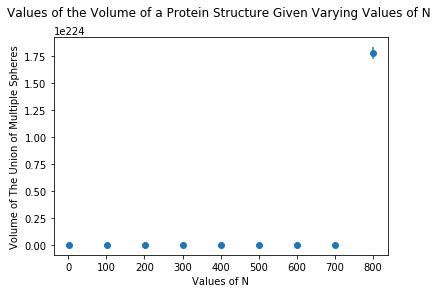

In [40]:
### This function works the same as the monte_carlo_many_spheres function above, but rather
### than returning the range for the calculation of the volume, it returns the volume and 
### the standard deviation of the volume.  It does this because we need the volume and the 
### standard deviation to be accessable seporately for graphing purposes.  
def get_volume_for_one_N(list_of_center_points_and_radii, number_of_points):
    cube_coordinates = get_cube_dimensions(list_of_center_points_and_radii)
    list_of_random_coodinates = get_list_of_random_coodinates(cube_coordinates[0], cube_coordinates[1], cube_coordinates[2], cube_coordinates[3], cube_coordinates[4], cube_coordinates[5],  number_of_points)
    for center_radius in list_of_center_points_and_radii:
        center_radius[3] = float(center_radius[3])*float(center_radius[3])
    points_within_circle = 0
    for coordinate in list_of_random_coodinates:
        for x_y_z_r in list_of_center_points_and_radii:
            circle_center = (float(x_y_z_r[0]), float(x_y_z_r[1]), float(x_y_z_r[2]))
            distance_to_center = get_distance_to_center(circle_center, coordinate)
            circle_radius = float(x_y_z_r[3])
            if distance_to_center <= circle_radius:
                points_within_circle += 1
                break
    ratio_in_to_out = points_within_circle/number_of_points  ### This is the "F" value
    volume_of_cube = get_volume_cube(cube_coordinates)
    SD_of_volume = get_SD_of_volume(ratio_in_to_out, volume_of_cube, number_of_points)
    volume_of_protein_structure = ratio_in_to_out*volume_of_cube
    return (volume_of_protein_structure, SD_of_volume)

### This function runs the monte_carlo_many_spheres function for every N value from 100 to 
### the max N value the user wishes to see on the graph in intervals of 100.  For each N, 
### it records the calculated volume and the standard deviation of the volume and links these
### values with the corresponding N value they came from by adding all of these items into 
### a list.  That list is added to a list containing a list for each N value.  This large list 
### of lists is returned. 
def get_list_of_Ns_Volumes_and_SE(txt_file, max_N):
    list_of_center_points_and_radii = read_in_data(txt_file)
    x_y_z = []
    for N in range(100, max_N, 100):  ##### change "step" to higher number for more efficiency
        volume_and_SE = get_volume_for_one_N(list_of_center_points_and_radii, N)
        volume = round(float(volume_and_SE[0]), 2)
        SE = round(float(volume_and_SE[1]), 2)
        x_y_z_value = [N, volume, SE]
        x_y_z.append(x_y_z_value)
    return(x_y_z)

### This function makes a generic error bar plot by taking in a list of X values, a list of
### Y values, and a list of Y error values.  It shows the user the graph that corresponds to 
### the way volume output changes given different N values
def make_N_vs_value_plot(x_list, y_list, y_error_list):
    plt.errorbar(x_list, y_list, yerr=y_error_list, fmt = 'o')
    plt.axhline(y=35490.34, color='r', linestyle='-')
    plt.xlabel("Values of N")
    plt.ylabel("Volume of The Union of Multiple Spheres")
    plt.title("Values of the Volume of a Protein Structure Given Varying Values of N \n")
    plt.show()

### This is the main function for graphing volumes given different values of N.  It generates 
### a list of Xs, made of the N values.  It also generates a list of Ys, the calculated volumes 
### and a list of errors determined by the volume standard deviations.  It calls the graph 
### functio so the corresponding graph will be shown.
def volume_and_N_graph():
    txt_file = input("Enter the name of a txt file which contains a center point and radius for each sphere in the protein structure you are looking at (ex. volume.txt): ")
    max_N = int(input("\nEnter the amount of maximum N value you want see on your graph: "))
    print("\nworking... this may take a while")
    list_Ns_Volumes_and_SE = get_list_of_Ns_Volumes_and_SE(txt_file, max_N)
    x_list = [x[0] for x in list_Ns_Volumes_and_SE]
    y_list = [x[1] for x in list_Ns_Volumes_and_SE]
    y_error_list = [x[2] for x in list_Ns_Volumes_and_SE]
    make_N_vs_value_plot(x_list, y_list, y_error_list)
    
volume_and_N_graph()

## Build a Graph to See How The Time it Takes to Calculate Volume Changes with Different N Values

In order to examinen the time complexity of our algorithm, we need to graph how long it takes to calculate the volume of the union of given spheres given different values of N.  The "function_to_be_timed" function is the same as the function above that we have implamented, but renamed for clairity.  Next we must create a list that contains the N values and the corresponding time it took for the "function_to_be_timed" function to run given that value of N.  We must create a function that can generate a scatterplot so that we can examine the data visually.  Finally we must use the "time_and_N_graph" to call all of the functions.  This will give us the graph we will need to understand the time complexity of the function that calculates the the volume of a protein with monte carlo integration.

Enter the name of a txt file which contains a center point and radius for each sphere in the protein structure you are looking at (ex. volume.txt): volume.txt

Enter the amount of maximum N value you want to test: 2000

working... this may take a while


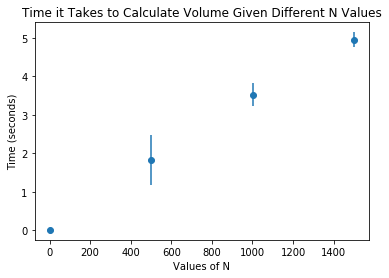

In [36]:
### This function works the same as the monte_carlo_many_spheres function and the 
### get_volume_for_one_N function but is retitled for clairity
def function_to_be_timed(list_of_center_points_and_radii, number_of_points):
    cube_coordinates = get_cube_dimensions(list_of_center_points_and_radii)
    list_of_random_coodinates = get_list_of_random_coodinates(cube_coordinates[0], cube_coordinates[1], cube_coordinates[2], cube_coordinates[3], cube_coordinates[4], cube_coordinates[5],  number_of_points)
    for center_radius in list_of_center_points_and_radii:
        center_radius[3] = float(center_radius[3])*float(center_radius[3])
    points_within_circle = 0
    for coordinate in list_of_random_coodinates:
        for x_y_z_r in list_of_center_points_and_radii:
            circle_center = (float(x_y_z_r[0]), float(x_y_z_r[1]), float(x_y_z_r[2]))
            distance_to_center = get_distance_to_center(circle_center, coordinate)
            circle_radius = float(x_y_z_r[3])
            if distance_to_center <= circle_radius:
                points_within_circle += 1
                break
    ratio_in_to_out = points_within_circle/number_of_points  ### This is the "F" value
    volume_of_cube = get_volume_cube(cube_coordinates)
    SD_of_volume = get_SD_of_volume(ratio_in_to_out, volume_of_cube, number_of_points)
    volume_of_protein_structure = ratio_in_to_out*volume_of_cube
    return (volume_of_protein_structure, SD_of_volume)

### This function records the time in seconds it takes to calculate the volume given an N 
### value.  It works by running the monte_carlo_many_spheres function for every value of N 
### from one to the maximum N value entered by the user in intervals of 500.  It runs each of
### the N values 10 times so that it can calculate an average time with a standard deviation. 
### It starts a timer, runs the function that is being timed, ends the timer and then records
### the time.  For each N it then calculates the average and standard deviation of the time 
### and then generates a list of the N value, the average time and the standard deviation of
### time.  It adds this list to a list of with the same values for other Ns and returns this 
### list of lists.
def get_list_Times_goven_Ns(txt_file, max_N):
    list_of_center_points_and_radii = read_in_data(txt_file)
    Ns_and_times = []
    for N in range(1, max_N, 500):  ### the "500" can be changed if you whish to not step by values of 500
        times = []
        for i in range(0,10):   ### the "10" can be how ever many times you want to repeat the process to determine standard deviation 
            start = timer()
            function_to_be_timed(list_of_center_points_and_radii, N)
            end = timer()
            time = round(end - start, 2)
            times.append(time)
        average_time = average(times)
        SE_time = standard_error(times, average_time)
        N_and_time = [N, average_time, SE_time]
        Ns_and_times.append(N_and_time)
    return(Ns_and_times)

### This function generates a standard graph with dots for the average value and error bars
### which correspond to the standard deviations.
def make_graph_with_error_bars(x_list, y_list, y_error_list):
    plt.errorbar(x_list, y_list, yerr=y_error_list, fmt = 'o')
    plt.xlabel("Values of N")
    plt.ylabel("Time (seconds)")
    plt.title("Time it Takes to Calculate Volume Given Different N Values")
    plt.show()

### This is the main function that takes necessary input from the user and shows the graph
### of how times change given different N values.  It takes in a maximum N value and the file
### the user is working with, runs the get_list_Times_goven_Ns function, and then turns those 
### results into a graph.
def time_and_N_graph():
    txt_file = input("Enter the name of a txt file which contains a center point and radius for each sphere in the protein structure you are looking at (ex. volume.txt): ")
    max_N = int(input("\nEnter the amount of maximum N value you want to see on your graph: "))
    print("\nworking... this may take a while")
    list_Ns_TimeAs_and_TimeSEs = get_list_Times_goven_Ns(txt_file, max_N)
    x_list = [x[0] for x in list_Ns_TimeAs_and_TimeSEs]
    y_list = [x[1] for x in list_Ns_TimeAs_and_TimeSEs]
    y_error_list = [x[2] for x in list_Ns_TimeAs_and_TimeSEs]
    make_graph_with_error_bars(x_list, y_list, y_error_list)


time_and_N_graph()